In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2

video_path = "G:/projekt gropwy/22.10.2025/video/raw/720p/5.1.mov"
cap = cv2.VideoCapture(video_path)

frames = []
frame_interval = 2
frame_counter = 0

target_height =360

while True:
    ret, frame = cap.read()
    if not ret:
        break

    if frame_counter % frame_interval == 0:
        # Get original dimensions
        h, w = frame.shape[:2]

        # Compute new width to preserve aspect ratio
        scale = target_height / h
        new_width = int(w * scale)

        # Resize frame
        resized_frame = cv2.resize(frame, (new_width, target_height), interpolation=cv2.INTER_AREA)
        frames.append(resized_frame)

    frame_counter += 1

cap.release()
print("Frames captured:", len(frames))
print("Resized frame shape:", frames[0].shape if frames else "No frames")

Frames captured: 2111
Resized frame shape: (360, 640, 3)


In [ ]:
cut_pixels = 200

# Crop all frames and overwrite the original frames list
frames = [frame[:, cut_pixels:] for frame in frames]

# Optional: check the shape of the first frame
print("Cropped frame size:", frames[0].shape[1], "x", frames[0].shape[0])


In [45]:
start_frame = 210

# Keep only frames after frame 210
frames = frames[start_frame:]

# Optional: check new number of frames
print("Number of frames after trimming:", len(frames))

Number of frames after trimming: 1901


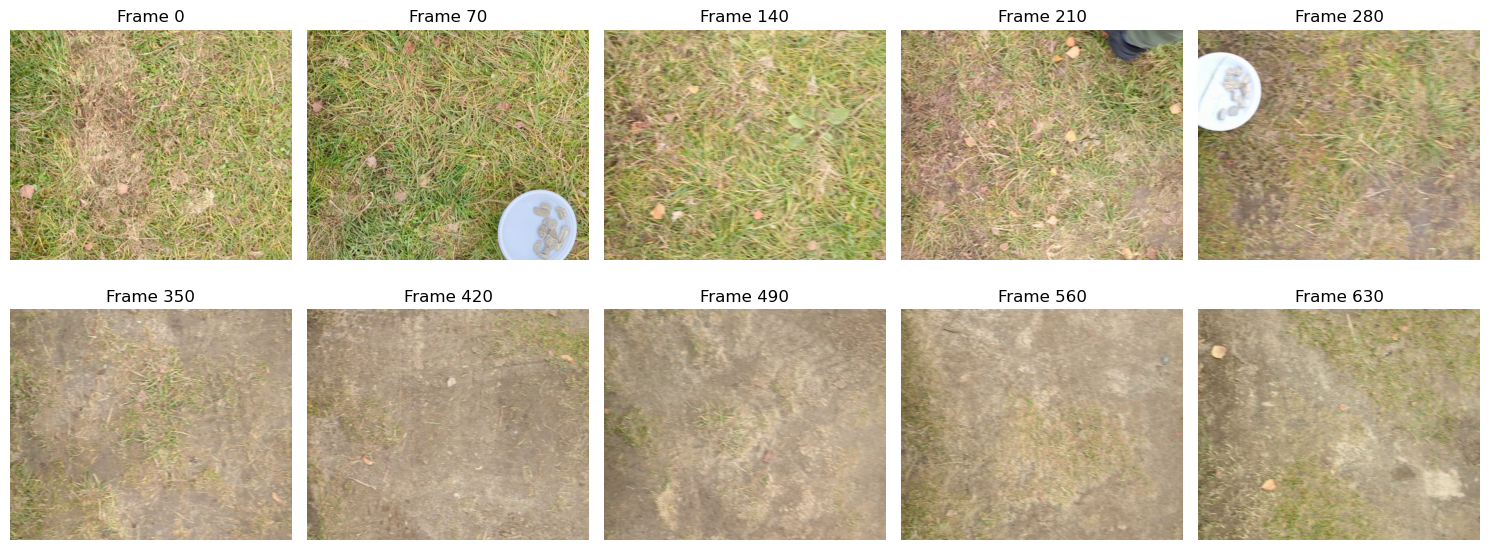

In [46]:



# Show first 10 frames
num_frames_to_show = 7
rows = math.ceil(num_frames_to_show / 5)
fig, axes = plt.subplots(rows, 5, figsize=(15, 6))  # 2 rows × 5 columns

for idx, ax in enumerate(axes.flat):
    idx = idx*70
    if idx < len(frames):
        frame_rgb = cv2.cvtColor(frames[idx], cv2.COLOR_BGR2RGB)
        ax.imshow(frame_rgb)
        ax.set_title(f"Frame {idx}")
        ax.axis("off")

plt.tight_layout()
plt.show()

In [39]:
def sparse_optical_flow(prev_gray, gray, prev_points=None):
    if prev_points is None:
        prev_points = cv2.goodFeaturesToTrack(
            prev_gray, mask=None,
            maxCorners=500, qualityLevel=0.3,
            minDistance=7, blockSize=7
        )

    lk_params = dict(
        winSize=(15, 15),
        maxLevel=2,
        criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
    )

    next_points, status, _ = cv2.calcOpticalFlowPyrLK(prev_gray, gray, prev_points, None, **lk_params)

    good_new = next_points[status == 1]
    good_old = prev_points[status == 1]

    motion = np.mean(good_new - good_old, axis=0)
    dx, dy = motion
    return dx, dy, next_points

In [40]:
def dense_optical_flow(prev_gray, gray):

    flow = cv2.calcOpticalFlowFarneback(
        prev_gray, gray, None,
        0.5, 3, 15, 3, 5, 1.2, 0
    )

    dx = np.mean(flow[..., 0])
    dy = np.mean(flow[..., 1])
    return dx, dy, flow

In [47]:
import cv2
import numpy as np

dense_motions = []  # (dx, dy) for Farneback

# Convert all frames to grayscale first
gray_frames = [cv2.cvtColor(f, cv2.COLOR_BGR2GRAY) for f in frames]

print("Starting optical flow computation...")
for i in range(1, len(gray_frames)):
    print(f"Processing frame {i}/{len(gray_frames) - 1}")

    prev_gray = gray_frames[i - 1]
    gray = gray_frames[i]

    # Dense Optical Flow (Farneback)
    flow = cv2.calcOpticalFlowFarneback(
        prev_gray, gray, None,
        pyr_scale=0.5, levels=3, winsize=15,
        iterations=3, poly_n=5, poly_sigma=1.2, flags=0
    )

    # Average motion over entire frame
    dx = np.mean(flow[..., 0])
    dy = np.mean(flow[..., 1])

    dense_motions.append([dx, dy])

dense_motions = np.array(dense_motions)

print("✅ Optical flow computation complete.")
print("Dense motions shape:", dense_motions.shape)
print("Example comparison (first 5 frames):")
for i in range(min(5, len(dense_motions))):
    print(f"Frame {i + 1}: Dense = {dense_motions[i]}")


Starting optical flow computation...
Processing frame 1/1900
Processing frame 2/1900
Processing frame 3/1900
Processing frame 4/1900
Processing frame 5/1900
Processing frame 6/1900
Processing frame 7/1900
Processing frame 8/1900
Processing frame 9/1900
Processing frame 10/1900
Processing frame 11/1900
Processing frame 12/1900
Processing frame 13/1900
Processing frame 14/1900
Processing frame 15/1900
Processing frame 16/1900
Processing frame 17/1900
Processing frame 18/1900
Processing frame 19/1900
Processing frame 20/1900
Processing frame 21/1900
Processing frame 22/1900
Processing frame 23/1900
Processing frame 24/1900
Processing frame 25/1900
Processing frame 26/1900
Processing frame 27/1900
Processing frame 28/1900
Processing frame 29/1900
Processing frame 30/1900
Processing frame 31/1900
Processing frame 32/1900
Processing frame 33/1900
Processing frame 34/1900
Processing frame 35/1900
Processing frame 36/1900
Processing frame 37/1900
Processing frame 38/1900
Processing frame 39/19

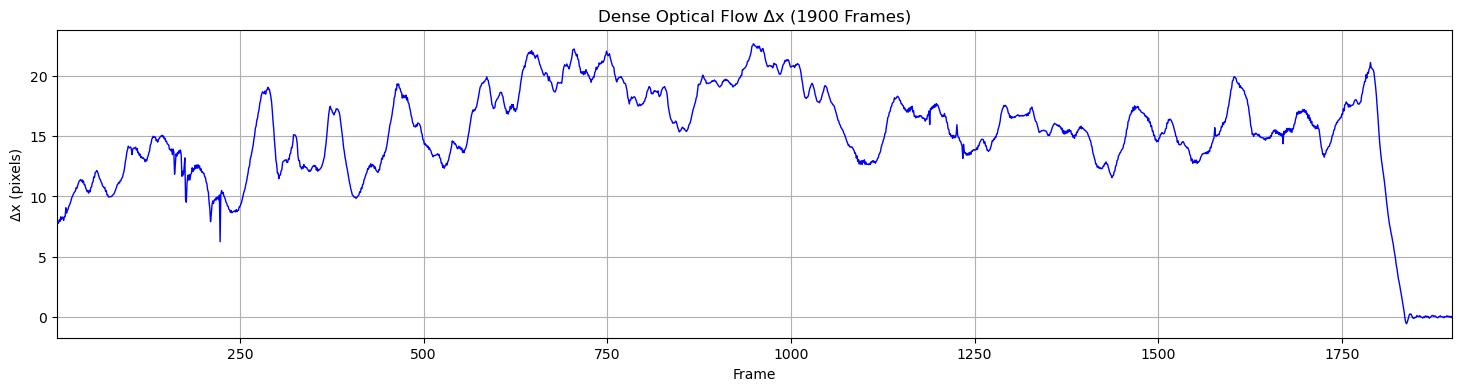

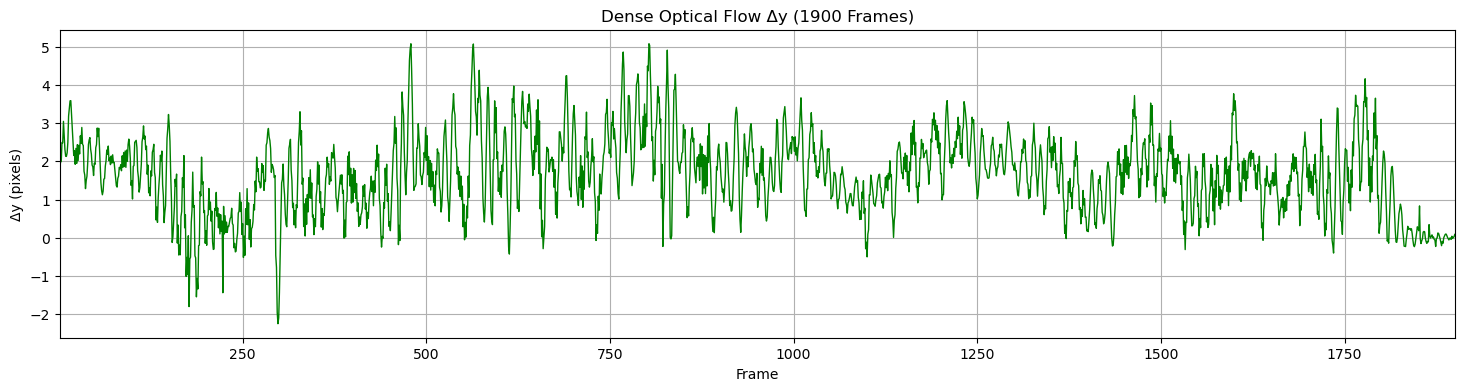

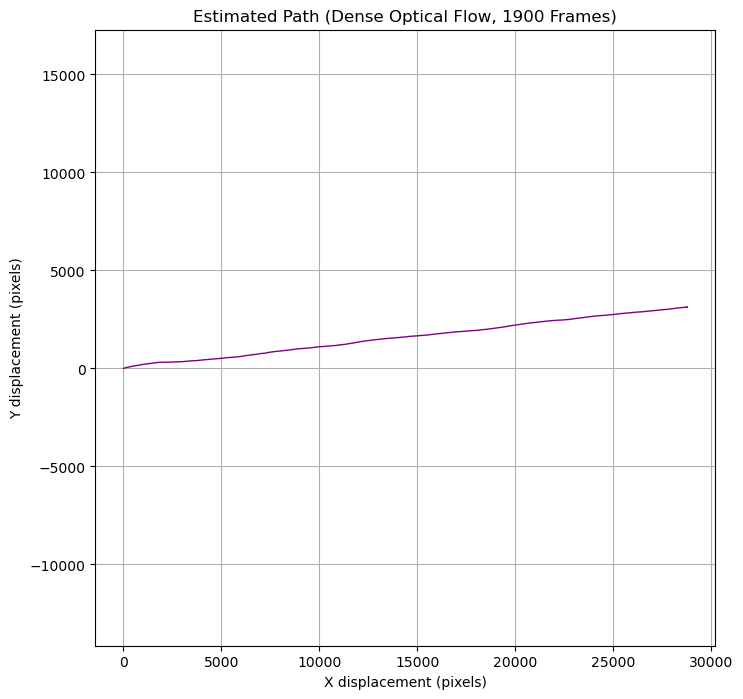

In [48]:
import matplotlib.pyplot as plt
import numpy as np

num_frames = dense_motions.shape[0]
frames_idx = np.arange(1, num_frames + 1)

# Split dx and dy
dense_dx = dense_motions[:, 0]
dense_dy = dense_motions[:, 1]

# --- Δx per frame ---
plt.figure(figsize=(18, 4))  # wide figure for all frames
plt.plot(frames_idx, dense_dx, color="blue", linewidth=1)
plt.title(f"Dense Optical Flow Δx ({num_frames} Frames)")
plt.xlabel("Frame")
plt.ylabel("Δx (pixels)")
plt.xlim(1, num_frames)  # show all frames
plt.grid(True)
plt.show()

# --- Δy per frame ---
plt.figure(figsize=(18, 4))
plt.plot(frames_idx, dense_dy, color="green", linewidth=1)
plt.title(f"Dense Optical Flow Δy ({num_frames} Frames)")
plt.xlabel("Frame")
plt.ylabel("Δy (pixels)")
plt.xlim(1, num_frames)
plt.grid(True)
plt.show()

# --- Integrated path ---
dense_path = np.cumsum(dense_motions, axis=0)

plt.figure(figsize=(8, 8))
plt.plot(dense_path[:, 0], dense_path[:, 1], color="purple", linewidth=1)
plt.title(f"Estimated Path (Dense Optical Flow, {num_frames} Frames)")
plt.xlabel("X displacement (pixels)")
plt.ylabel("Y displacement (pixels)")
plt.axis("equal")
plt.grid(True)
plt.show()


Total Y pixels (max - min): 3265.01
Scale (meters per pixel, Y only): 0.0031


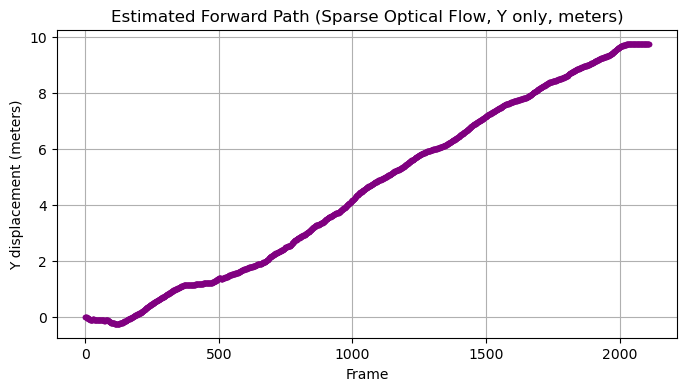

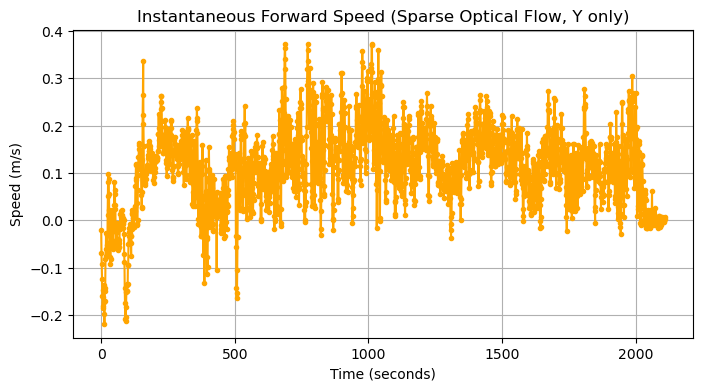

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Extract Y motion from sparse optical flow ---
sparse_dy = dense_motions[:, 1]  # Y motion in pixels

# --- 2. Handle NaNs/Infs ---
sparse_dy_clean = np.nan_to_num(sparse_dy, nan=0.0, posinf=0.0, neginf=0.0)

# --- 3. Compute cumulative Y path in pixels ---
sparse_path_y = np.cumsum(sparse_dy_clean)

# --- 4. Compute scale using known track length ---
real_length_m = 10.0  # meters

# Use max-min to account for any backward motion
total_pixels_y = np.max(sparse_path_y) - np.min(sparse_path_y)
scale = real_length_m / total_pixels_y

print(f"Total Y pixels (max - min): {total_pixels_y:.2f}")
print(f"Scale (meters per pixel, Y only): {scale:.4f}")

# --- 5. Convert Y motion to meters ---
sparse_dy_m = sparse_dy_clean * scale
sparse_path_y_m = np.cumsum(sparse_dy_m)

# --- 6. Plot cumulative Y displacement in meters ---
plt.figure(figsize=(8, 4))
plt.plot(sparse_path_y_m, '-o', color='purple', markersize=3)
plt.title("Estimated Forward Path (Sparse Optical Flow, Y only, meters)")
plt.xlabel("Frame")
plt.ylabel("Y displacement (meters)")
plt.grid(True)
plt.show()

# --- 7. Optional: Compute instantaneous speed in m/s ---
fps = 24# frames per second
speed_m_per_s = sparse_dy_m * fps

# Create a time (seconds) array for x-axis
time_s = np.arange(len(speed_m_per_s)) / fps *24

plt.figure(figsize=(8, 4))
plt.plot(time_s, speed_m_per_s, '-o', color='orange', markersize=3)
plt.title("Instantaneous Forward Speed (Sparse Optical Flow, Y only)")
plt.xlabel("Time (seconds)")
plt.ylabel("Speed (m/s)")
plt.grid(True)
plt.show()

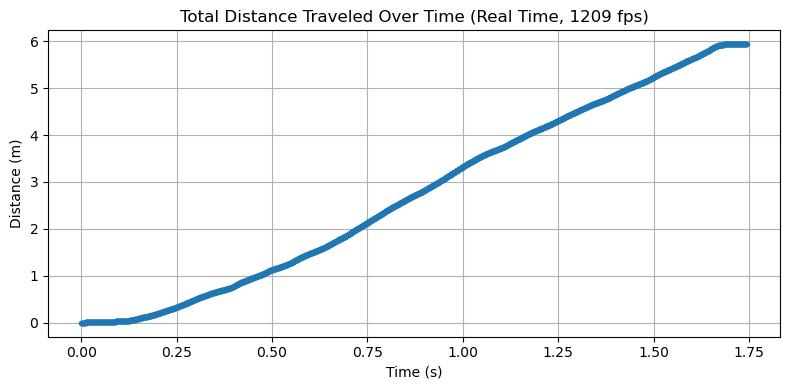

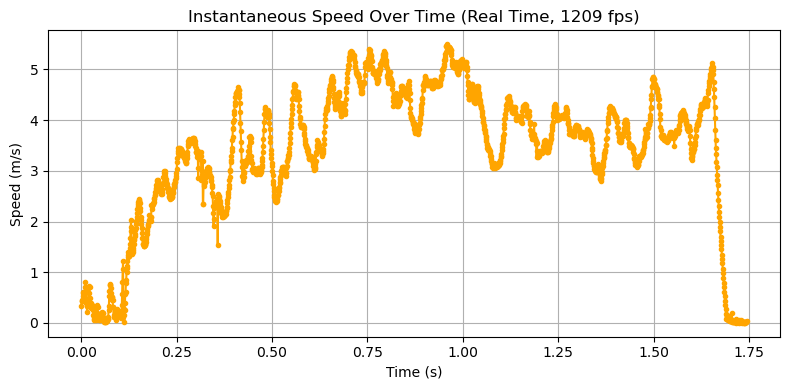

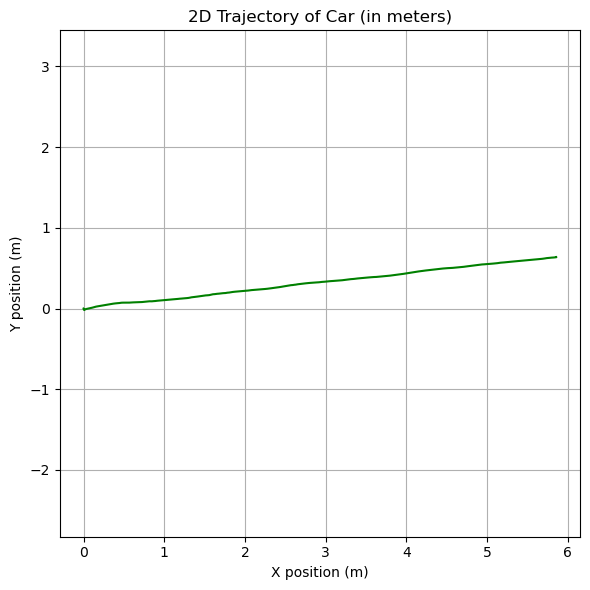

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# --- Known parameters ---
fps_capture = 1209
scale_correction = 1080/target_height # real capture frame rate
meters_per_pixel_y = 0.0006
meters_per_pixel_y = meters_per_pixel_y / scale_correction

# scale (meters per pixel)
# assuming same scale in X (most cameras have square pixels)

# --- Example data placeholders ---
# Replace these with your actual motion arrays from optical flow:
# dense_dx_px = np.array([...])
# dense_dy_px = np.array([...])

# --- 4. Convert to meters ---
dense_dx_m = dense_dx * meters_per_pixel_y
dense_dy_m = dense_dy * meters_per_pixel_y

# --- 5. Compute distances and speed ---
dense_disp_m = np.sqrt(dense_dx_m**2 + dense_dy_m**2)  # per-frame displacement
distance_m = np.cumsum(dense_disp_m)                   # cumulative distance
speed_m_per_s = dense_disp_m * fps_capture             # instantaneous speed

# --- 6. Build time axis (real-time) ---
time_s = np.arange(len(distance_m)) / fps_capture

# --- 7. Plot total distance over time ---
plt.figure(figsize=(8, 4))
plt.plot(time_s, distance_m, '-o', markersize=3)
plt.title("Total Distance Traveled Over Time (Real Time, 1209 fps)")
plt.xlabel("Time (s)")
plt.ylabel("Distance (m)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 8. Plot instantaneous speed over time ---
plt.figure(figsize=(8, 4))
plt.plot(time_s, speed_m_per_s, '-o', color='orange', markersize=3)
plt.title("Instantaneous Speed Over Time (Real Time, 1209 fps)")
plt.xlabel("Time (s)")
plt.ylabel("Speed (m/s)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 9. Plot 2D trajectory ---
distance_x_m = np.cumsum(dense_dx_m)
distance_y_m = np.cumsum(dense_dy_m)

plt.figure(figsize=(6, 6))
plt.plot(distance_x_m, distance_y_m, '-', color='green')
plt.title("2D Trajectory of Car (in meters)")
plt.xlabel("X position (m)")
plt.ylabel("Y position (m)")
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()
